<a href="https://colab.research.google.com/github/papapabi/wandb-experiments/blob/main/nlp_aes_holistic_scoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automated Exam Scoring - Holistic

Task: assigning a discrete value (a single integer score from 1-6 due to dataset) for an entire essay

## Setup

In [ ]:
!pip install wandb==0.23.0 evaluate datasets transformers

In [ ]:
import os
from google.colab import userdata

# Declare a Secret in Colab and paste your own W&B API key
os.environ["WANDB_API_KEY"] = userdata.get("WANDB_API_KEY")
# Optional: declare a Secret in Colab and paste your own HF access token
os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")

import wandb

wandb.login()

## Dataset and methodology scratchpad

[Automated Student Assessment Prize (ASAP 2.0)](https://github.com/scrosseye/ASAP_2.0) - from Kaggle
- persuasive essays written by 6th, 8th, 9th, and 10th grade students, with 7 writing prompts in total
- this is slightly modified from the [original competition dataset](https://www.kaggle.com/competitions/learning-agency-lab-automated-essay-scoring-2), which only contained essay_id, full_text, and score
- ~24728 unique rows (verified below) - we need to make train/val/test splits ourselves
- columns of interest/input features
    - score ([holistic score description](https://storage.googleapis.com/kaggle-forum-message-attachments/2733927/20538/Rubric_%20Holistic%20Essay%20Scoring.pdf)) - an integer in the range [1, 6]
    - full_text - actual essay content
    - essay_id - can be used to check for uniqueness/deduplication
- other columns/metadata provided not in the original competition dataset: economically_disadvantaged, student_disability_status, ell_status, race_ethnicity, gender
    - Using these as input features effectively encodes discrimination into the system, so they should not be used as input features
    - But we can use them to check and prove that the fine-tuned model is not biased to any of these metadata - **for future work**
- other interesting/to-explore columns:
    - assignment - the writing prompt to produce the essay - find a way to incorporate this into fine-tuning and inference - **for future work**
        - one way is to do prompt-based fine-tuning, by prepending the raw prompt text or ID-encoded prompt before the essay (full_text)
    - source_text_[1-4] - contains the reference reading passages that students were expected to use, analyze, summarize, or respond to in their essays

Metric: [Quadratic Weighted Kappa (QWK)](https://www.kaggle.com/competitions/learning-agency-lab-automated-essay-scoring-2/overview/evaluation) - it effectively penalizes larger score discrepancies more heavily than smaller ones, reflecting the ordinal nature of essay scores (e.g., assigning a score of 6 to a true value of 1 is a bigger error than assigning 3 vs. 1)
- going with this, the loss function needs to reflect that ordinal nature too (see later section Ordinal regression - CORAL)
- according to https://arxiv.org/html/2509.10417v1, human-human rater agreement has a QWK at 0.745.


Immediates:
1. check for nans and undesirables in columns of interest - no undesirables ✅
2. check for uniqueness using essay_id - all texts are unique ✅
2. full_text - estimate token length via simple estimate of word length to determine if we need to get creative with a tokenizer (head+tail truncation, sliding window) or use a transformer with a large context window like longformer

Model candidates post-EDA:
- 99% of the dataset (full_text) falls below ~1216 tokens (computed via a heuristic)
    - pretrained model candidates - `ModernBERT` (can handle sequence lengths up to 8192 tokens), `microsoft/deberta-v3-*`, `longformer`, `edubert` - going with `ModernBERT` for now

## Get dataset from Kaggle


In [ ]:
!pip install kagglehub

To execute the following cells, you must set a Colab Secret named `KAGGLE_API_TOKEN` in your notebook environment:

In [ ]:
import kagglehub
from google.colab import userdata
import os

os.environ["KAGGLE_API_TOKEN"] = userdata.get("KAGGLE_API_TOKEN")

In [ ]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

raw_dataset = kagglehub.dataset_load(
    KaggleDatasetAdapter.HUGGING_FACE,
    "lburleigh/asap-2-0",
    "ASAP2_train_sourcetexts.csv",
)

100%|██████████| 199M/199M [00:04<00:00, 51.1MB/s]


In [ ]:
raw_dataset

Dataset({
    features: ['essay_id', 'score', 'full_text', 'assignment', 'prompt_name', 'economically_disadvantaged', 'student_disability_status', 'ell_status', 'race_ethnicity', 'gender', 'source_text_1', 'source_text_2', 'source_text_3', 'source_text_4'],
    num_rows: 24728
})

## Exploratory data analysis (EDA)

### Check for NaNs and invalid values in columns of interest

In [ ]:
def check_invalid_counts(dataset):
    ds = dataset

    # Check for NaNs or out-of-range in 'score'
    invalid_score = ds.filter(lambda x: x['score'] is None or x['score'] not in [1, 2, 3, 4, 5, 6])
    # Check for NaNs or non-string/empty in 'full_text'
    invalid_text = ds.filter(lambda x: x['full_text'] is None or not isinstance(x['full_text'], str) or len(x['full_text'].strip()) == 0)
    # Check for NaNs or non-string/empty in 'assignment'
    invalid_assignment = ds.filter(lambda x: x['assignment'] is None or not isinstance(x['assignment'], str) or len(x['assignment'].strip()) == 0)

    print(f"Total rows: {len(ds)}")
    print(f"Invalid scores: {len(invalid_score)}")
    print(f"Invalid/empty text: {len(invalid_text)}")
    print(f"Invalid/empty assignment: {len(invalid_assignment)}")

check_invalid_counts(raw_dataset)

Filter:   0%|          | 0/24728 [00:00<?, ? examples/s]

Filter:   0%|          | 0/24728 [00:00<?, ? examples/s]

Filter:   0%|          | 0/24728 [00:00<?, ? examples/s]

Total rows: 24728
Invalid scores: 0
Invalid/empty text: 0
Invalid/empty assignment: 0


### Check for duplicates using essay_id

Fast check before doing anything else:

In [ ]:
num_rows = len(raw_dataset)
num_unique = len(raw_dataset.unique("essay_id"))

if num_rows > num_unique:
    print(f"⚠️ Found {num_rows - num_unique} duplicates!")
else:
    print("✅ All essay_id values are unique.")

✅ All essay_id values are unique.


### Check word length as a heuristic for token length

Goal: check 95th and 99th percentile (descriptive stats in general) of a derived `word_count` column, using the simple `str.split()` as a heuristic for token count, keeping in mind that subword tokenization used by most models typically produces 1.3-1.5 tokens per word.

In [ ]:
def count_words(batch: dict[str, list]) -> dict[str, list]:
    batch['word_count'] = [len(e.split()) for e in batch['full_text']]
    # using 1.5 as a worst-case upper bound
    batch['approximate_token_count'] = [e*1.5 for e in batch['word_count']]
    return batch

# Apply to the dataset
raw_dataset = raw_dataset.map(count_words, batched=True)

Map:   0%|          | 0/24728 [00:00<?, ? examples/s]

In [ ]:
import numpy as np

token_counts = raw_dataset['approximate_token_count']

print(f"Mean token count: {np.mean(token_counts):.2f}")
print(f"Median token count: {np.median(token_counts)}")
print(f"Max token count: {np.max(token_counts)}")
print(f"90th percentile: {np.percentile(token_counts, 90)}")
print(f"95th percentile: {np.percentile(token_counts, 95)}")
print(f"99th percentile: {np.percentile(token_counts, 99)}")

Mean token count: 544.35
Median token count: 507.0
Max token count: 2484.0
90th percentile: 837.0
95th percentile: 963.0
99th percentile: 1216.5


Visualize the distribution and mark common model context window/`max_pos_embeddings` limits:

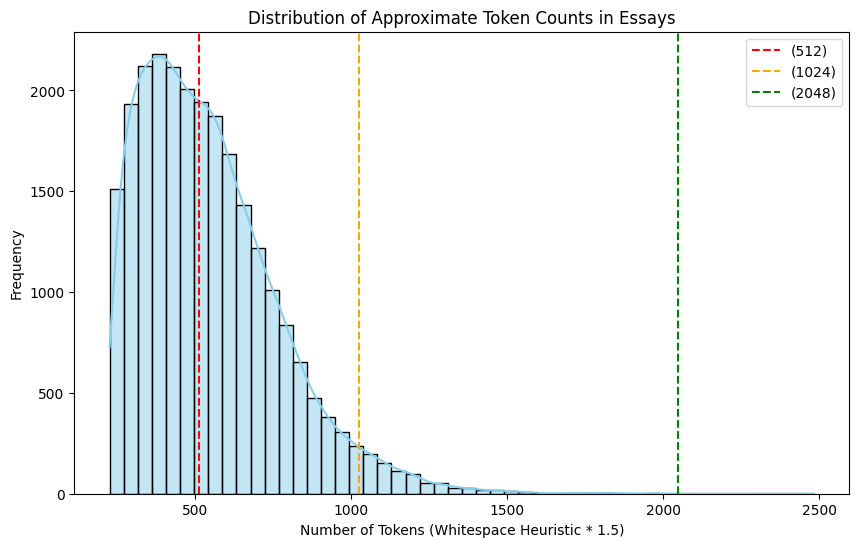

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(token_counts, bins=50, kde=True, color='skyblue')

# Context window markers for common models
plt.axvline(512, color='red', linestyle='--', label='(512)')
plt.axvline(1024, color='orange', linestyle='--', label='(1024)')
plt.axvline(2048, color='green', linestyle='--', label='(2048)')
#plt.axvline(8192, color='pink', linestyle='--', label='(8192)')

plt.title("Distribution of Approximate Token Counts in Essays")
plt.xlabel("Number of Tokens (Whitespace Heuristic * 1.5)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

Insights:
- the ASAP 2.0 dataset is already cleaned and mostly ready pre-tokenization and encoding
- data has a significant long tail, with the longest essay being ~2484 tokens
- a model under the traditional BERT family (~512 tokens) will truncate nearly half (acc to median) of the essays unless a custom truncation/tokenization strategy is used such as head-tail or sliding window
    - with standard truncation, a model will effectively grade the essay while possibly ignoring the entire conclusion
- 99% of the data falls below ~1216 tokens
    - pretrained model candidates - `ModernBERT` (can handle sequence lengths up to 8192 tokens), `microsoft/deberta-v3-*`, `longformer`

### Check the distribution of 'score' column

In [ ]:
import pandas as pd

raw_dataset.set_format('pandas')
df = raw_dataset[:]

# Get counts and percentages
distribution = df['score'].value_counts(normalize=False).sort_index()
percentages = df['score'].value_counts(normalize=True).sort_index() * 100

print(pd.concat([distribution, percentages], axis=1, keys=['Count', 'Percentage (%)']))

raw_dataset.reset_format()

       Count  Percentage (%)
score                       
1       1751        7.081042
2       6847       27.689259
3       9021       36.480912
4       5553       22.456325
5       1356        5.483662
6        200        0.808800


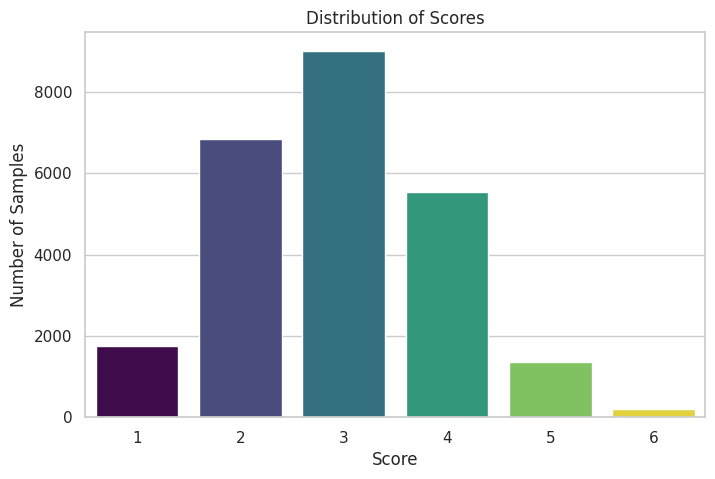

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
sns.set_theme(style="whitegrid")

# Create a bar plot
plt.figure(figsize=(8, 5))
sns.countplot(x=raw_dataset['score'], hue=raw_dataset['score'], palette="viridis", legend=False)

plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Number of Samples')
plt.show()

Scores 1, 5, and 6 are rare so we have to take care of preserving this distribution when we split the dataset into train/val/test.

## Sequential stratified sampling to split the raw dataset into train/val/test

Goal: 60/20/20 train/val/test split for the resulting `datasets.DatasetDict` with distributions for `score` preserved as much as possible.

Why?
- Validation and test scores will be more representative of the model's true performance across the entire range of possible scores.
- Stratification ensures 'rare' scores are represented in every split (according to EDA above, only  0.808800% got a perfect score of 6)
- Prevents the accidental case due to sheer bad luck where we end up with no examples in a split (e.g., no score 6 in the test or val set)

### Cast the 'score' column prior to stratification

We need to cast the 'score' column into a `datasets.ClassLabel` column to be able to do straified sampling.

Using the names provided by the [rubric](https://storage.googleapis.com/kaggle-forum-message-attachments/2733927/20538/Rubric_%20Holistic%20Essay%20Scoring.pdf):

In [ ]:
from datasets import ClassLabel, Features

# Shift values from 1-6 to 0-5, since datasets.ClassLabel expects 0-indexed values
ds = raw_dataset.map(lambda x: {"score": x["score"] - 1})

# Define the new ClassLabel feature
# The names list corresponds to the labels for 0, 1, 2, 3, 4, 5
new_features = raw_dataset.features.copy()
new_features["score"] = ClassLabel(names=['very little mastery', 'little mastery', 'developing mastery', 'adequate mastery', 'reasonably consistent mastery', 'clear and consistent mastery'])

# Cast the column
ds = ds.cast_column("score", new_features["score"])

Map:   0%|          | 0/24728 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/24728 [00:00<?, ? examples/s]

In [ ]:
# Quick verification
print(f"{ds.features["score"]=}")
print(f"{ds[0]["score"]=}")  # Returns the integer (0-5)
print(ds.features["score"].int2str(ds[0]["score"])) # Returns the string label

ds.features["score"]=ClassLabel(names=['very little mastery', 'little mastery', 'developing mastery', 'adequate mastery', 'reasonably consistent mastery', 'clear and consistent mastery'])
ds[0]["score"]=3
adequate mastery


### Stratified sampling to get train/val/test

In [ ]:
# after this stage, ds returns a datasets.DatasetDict with 'train' and 'test' keys
# the split with the 'test' key will be our temporary pool to split again to get the final 'val' and 'test' keys
temp_dataset_dict = ds.train_test_split(
    test_size=0.4,
    shuffle=True,
    stratify_by_column="score",
    seed=42,
)

In [ ]:
val_test_dict = temp_dataset_dict["test"].train_test_split(
    test_size=0.5,  # 50% of the remaining 40%, resulting in 20% for validation, and 20% for test
    shuffle=True,
    stratify_by_column="score",
    seed=42,
)

In [ ]:
from datasets import DatasetDict

dataset_dict = DatasetDict(
    {
        'train': temp_dataset_dict['train'],
        'validation': val_test_dict['train'],
        'test': val_test_dict['test'],
    }
)

In [ ]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['essay_id', 'score', 'full_text', 'assignment', 'prompt_name', 'economically_disadvantaged', 'student_disability_status', 'ell_status', 'race_ethnicity', 'gender', 'source_text_1', 'source_text_2', 'source_text_3', 'source_text_4', 'word_count', 'approximate_token_count'],
        num_rows: 14836
    })
    validation: Dataset({
        features: ['essay_id', 'score', 'full_text', 'assignment', 'prompt_name', 'economically_disadvantaged', 'student_disability_status', 'ell_status', 'race_ethnicity', 'gender', 'source_text_1', 'source_text_2', 'source_text_3', 'source_text_4', 'word_count', 'approximate_token_count'],
        num_rows: 4946
    })
    test: Dataset({
        features: ['essay_id', 'score', 'full_text', 'assignment', 'prompt_name', 'economically_disadvantaged', 'student_disability_status', 'ell_status', 'race_ethnicity', 'gender', 'source_text_1', 'source_text_2', 'source_text_3', 'source_text_4', 'word_count', 'approx

Quick sanity check to see if the distribution was actually preserved:

In [ ]:
import pandas as pd
from datasets import DatasetDict


def calculate_distribution_percentages(
    dataset_dict: DatasetDict, label_column: str = "score"
) -> pd.DataFrame:
    """
    Calculates the percentage distribution for each split in a DatasetDict.
    """
    distribution_data = {}

    for split_name, dataset in dataset_dict.items():
        # get label counts for a particular split
        counts = dataset.to_pandas()[label_column].value_counts()
        total = len(dataset)
        percentages = (counts / total) * 100
        distribution_data[split_name] = percentages

    # Convert the results to a DataFrame for easy comparison
    distribution_df = pd.DataFrame(distribution_data).fillna(0)

    # Sort by class label for consistent viewing
    distribution_df.sort_index(inplace=True)

    return distribution_df


distribution_table = calculate_distribution_percentages(dataset_dict)


print("Class Distribution Comparison (Percentages %)")
print(distribution_table.round(2))

Class Distribution Comparison (Percentages %)
       train  validation   test
score                          
0       7.08        7.10   7.08
1      27.69       27.68  27.70
2      36.48       36.47  36.49
3      22.46       22.46  22.44
4       5.49        5.48   5.48
5       0.81        0.81   0.81


## Encode text (tokenize + encode)

`transformers.Trainer` expects the `score` column to be named `labels`:

In [ ]:
final_dataset_dict = dataset_dict.rename_column("score", "labels")

In [ ]:
from transformers import AutoTokenizer

checkpoint = 'answerdotai/ModernBERT-base'
max_pos_embeddings = 8192 # modernbert max sequence length

tokenizer = AutoTokenizer.from_pretrained(
    checkpoint
)

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

Defer padding and use dynamic padding later:

In [ ]:
def encode_text(batch: dict[str, list]) -> dict[str, list]:
    return tokenizer(batch['full_text'], truncation=True, max_length=max_pos_embeddings)

In [ ]:
encoded_datasets = final_dataset_dict.map(
    encode_text, batched=True,
)

Map:   0%|          | 0/14836 [00:00<?, ? examples/s]

Map:   0%|          | 0/4946 [00:00<?, ? examples/s]

Map:   0%|          | 0/4946 [00:00<?, ? examples/s]

In [ ]:
encoded_datasets

DatasetDict({
    train: Dataset({
        features: ['essay_id', 'labels', 'full_text', 'assignment', 'prompt_name', 'economically_disadvantaged', 'student_disability_status', 'ell_status', 'race_ethnicity', 'gender', 'source_text_1', 'source_text_2', 'source_text_3', 'source_text_4', 'word_count', 'approximate_token_count', 'input_ids', 'attention_mask'],
        num_rows: 14836
    })
    validation: Dataset({
        features: ['essay_id', 'labels', 'full_text', 'assignment', 'prompt_name', 'economically_disadvantaged', 'student_disability_status', 'ell_status', 'race_ethnicity', 'gender', 'source_text_1', 'source_text_2', 'source_text_3', 'source_text_4', 'word_count', 'approximate_token_count', 'input_ids', 'attention_mask'],
        num_rows: 4946
    })
    test: Dataset({
        features: ['essay_id', 'labels', 'full_text', 'assignment', 'prompt_name', 'economically_disadvantaged', 'student_disability_status', 'ell_status', 'race_ethnicity', 'gender', 'source_text_1', 'source

The only pertinent columns for fine-tuning are `labels`, `input_ids`, and `attention_mask`.

## Ordinal regression - CORAL

COnsistent RAnk Logits (CORAL) is a methodology for doing ordinal regression using neural networks. In ordinal regression, target labels have a meaningful order (like in our case, original scores are 1-6 which was mapped to zero-indexed 0-5), but the difference between ranks is not uniform or continuous like in standard regression tasks.

The key feature of the CORAL method is that it transforms the ordinal regression problem into **a series of binary classification tasks while enforcing a weight-sharing constraint in the final layer of the neural network.** This ensures that the predictions are rank-consistent, meaning the model is less likely to predict a higher rank when a lower rank would be more appropriate given the data.

Regression vs CORAL
- While regression often implies predicting a continuous value, the CORAL method falls under the specific category of ordinal regression, which sits between classification and continuous regression.
- It leverages the ordered nature of the labels, providing more structured and better-calibrated predictions than simple scalar regression which treats labels as arbitrary continuous numbers.

In our case, it'll force the model to learn that a score of 4 is greater than 3, which is greater than 2, and so on, which standard classification ignores.

Instead of asking the model "Which of these 6 categories is it?", we ask it 5 binary questions:

1. Is the score > 0? (original score 1 after casting)
2. Is the score > 1? (original score 2 after casting)
3. Is the score > 2? (and so on)
4. Is the score > 3?
5. Is the score > 4?


Links and references for the methodology:
- https://github.com/Raschka-research-group/coral-pytorch
- https://arxiv.org/abs/2111.08851

### Label encoding

Transform the integer labels (0-5) into a binary vector of length (5).

- 0 > [0, 0, 0, 0, 0]
- 1 > [1, 0, 0, 0, 0]
- 2 > [1, 1, 0, 0, 0]
- 3 > [1, 1, 1, 0, 0]
- 4 > [1, 1, 1, 1, 0]
- 5 > [1, 1, 1, 1, 1]

In [ ]:
def encode_ordinal_labels(batch: dict[str, list]) -> dict[str, list]:
    # Map 0 -> [0,0,0,0,0], 1 -> [1,0,0,0,0], ..., 5 -> [1,1,1,1,1]
    labels = np.array(batch["labels"])
    ordinal_labels = []
    for lbl in labels:
        # Create a vector of 5: fill 'lbl' number of slots with 1s
        vec = [1] * lbl + [0] * (5 - lbl)
        ordinal_labels.append(vec)

    batch["labels"] = ordinal_labels
    return batch

In [ ]:
label_encoded_datasets = encoded_datasets.map(encode_ordinal_labels, batched=True)

Map:   0%|          | 0/14836 [00:00<?, ? examples/s]

Map:   0%|          | 0/4946 [00:00<?, ? examples/s]

Map:   0%|          | 0/4946 [00:00<?, ? examples/s]

## Defining a transformer that understands the Ordinal Regression task

We need to create a class that wraps the base model and adds a head that understands the CORAL encodings.

By using `self.fc = nn.Linear(hidden_size, 1, bias=False)` and adding a bias vector of length 5 (num of labels - 1), we guarantee that the "importance" of the features is the same for every threshold, which is the core of ordinal logic.

We also add some flags for checkpointing so `Trainer` can talk to `self.transformer` to handle `gradient_checkpointing=True`:

In [ ]:
import torch
import torch.nn as nn
from transformers import AutoModel

class TransformerOrdinal(nn.Module):
    def __init__(self, model_name, num_labels=6):
        super().__init__()
        self.transformer = AutoModel.from_pretrained(model_name)
        hidden_size = self.transformer.config.hidden_size

        # CORAL heads
        self.fc = nn.Linear(hidden_size, 1, bias=False)
        self.bias = nn.Parameter(torch.zeros(num_labels - 1))

    def gradient_checkpointing_enable(self, **kwargs):
        self.transformer.gradient_checkpointing_enable(**kwargs)

    def gradient_checkpointing_disable(self):
        self.transformer.gradient_checkpointing_disable()

    def _set_gradient_checkpointing(self, enable, **kwargs):
        if enable:
            self.transformer.gradient_checkpointing_enable(**kwargs)
        else:
            self.transformer.gradient_checkpointing_disable()

    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.transformer(input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]

        logits = self.fc(pooled_output) + self.bias

        loss = None
        if labels is not None:
            # We use BCE for each of the 5 binary tasks
            loss_fn = nn.BCEWithLogitsLoss()
            loss = loss_fn(logits, labels.float())

        return {"loss": loss, "logits": logits} if loss is not None else logits

In [ ]:
model = TransformerOrdinal(model_name=checkpoint)

## Setup required Trainer objects

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
from transformers import EvalPrediction
from sklearn.metrics import cohen_kappa_score
import numpy as np

def compute_metrics(eval_pred: EvalPrediction):
    logits, labels = eval_pred

    # Convert logits to probabilities
    probs = 1 / (1 + np.exp(-logits))

    # Get the discrete 0-5 score (summing the "Yes" answers)
    predictions = (probs > 0.5).sum(axis=1)

    # Get the true 0-5 score (Summing the binary vector [1,1,0,0,0] -> 2)
    true_labels = labels.sum(axis=1)

    # Calculate Quadratic Weighted Kappa
    # Note: weights="quadratic" is the key here
    qwk = cohen_kappa_score(true_labels, predictions, weights="quadratic")

    # Traditional metrics
    mae = np.mean(np.abs(predictions - true_labels))
    accuracy = (predictions == true_labels).mean()

    return {
        "qwk": qwk,
        "mae": mae,
        "accuracy": accuracy
    }

The only pertinent columns are `input_ids`, `attention_mask`, and `labels`:

In [ ]:
columns_to_keep = ['input_ids', 'attention_mask', 'labels']
cols_to_remove = [col for col in label_encoded_datasets['train'].column_names if col not in columns_to_keep]
label_encoded_datasets = label_encoded_datasets.remove_columns(cols_to_remove)
label_encoded_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 14836
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 4946
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 4946
    })
})

In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-6,
    per_device_train_batch_size=8,
    num_train_epochs=1,
    metric_for_best_model="qwk", # Optimize for QWK
    greater_is_better=True,
    load_best_model_at_end=True,
    fp16=True,
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant": False}, # Recommended for modern PyTorch
    #weight_decay=0.01,
    #warmup_ratio=0.1
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=label_encoded_datasets['train'],
    eval_dataset=label_encoded_datasets['validation'],
    compute_metrics=compute_metrics,
    processing_class=tokenizer,
    data_collator=data_collator,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Qwk,Mae,Accuracy
1,0.613900,0.596143,0.477954,1.623736,0.081278


TrainOutput(global_step=928, training_loss=0.6063551409491177, metrics={'train_runtime': 1559.532, 'train_samples_per_second': 9.513, 'train_steps_per_second': 0.595, 'total_flos': 0.0, 'train_loss': 0.6063551409491177, 'epoch': 1.0})

## Data pipeline in W&B

Using the steps outlined in previous notebook sections, we can create a functional W&B pipeline.

**1. Ingest**
- Goal: Get raw dataset from Kaggle and cast into a `datasets.Dataset` object with no modifications
- Dependency: needs a `KAGGLE_API_TOKEN` set in Colab Secrets

Steps:
- Get raw dataset from Kaggle using `kagglehub`
- Cast into a `datasets.Dataset` object
- Log as a `asap-2-raw` artifact with no modifications in Arrow format

**2. Clean**
- Goal: make a general, stable, clean data source that can be used prior to encoding, which can change depending on the transformer architecture used.
    - note: the data is already cleaned according to EDA

Steps:
- Take in `asap-2-raw` as an input dependency
- Cast the `score` column to a `ClassLabel` column to get stratified train/val/test splits using `score` as the reference column
- Perform stratified sampling to split the dataset into configurable split ratios (60/20/20 by default)
- Log as a `asap-2-clean` artifact in Arrow format

**3. Tokenize and encode**
- Goal: Get tokenized+encoded elements (`input_ids`, `attention_mask`) from `full_text` as well as performing label encoding to `score` according to CORAL method
    - the output artifact after this phase will be ready for fine-tuning
    - **NOTE:** the extra `dataset.Dataset` features will not be removed at this phase such as `full_text`, `essay_id`, etc
    - It will be up to the fine-tuning code to drop all of the irrelevant columns so we can use these extra features for evaluation

Steps:
- Take in `asap-2-clean` as an input dependency
- Rename the `score` column to `labels`
- Perform tokenization and encoding using the desired base model (ModernBert by default)
- Perform label encoding on the `labels` column
- Remove extraneous columns not required by `Trainer`


### 1: Ingest

In [11]:
!pip install kagglehub

In [12]:
import sys
import tempfile

import kagglehub
import wandb
from kagglehub import KaggleDatasetAdapter
from wandb.sdk.wandb_run import Run  # Type hint for the run object


def ingest_data(
    run: Run, dataset_id, filename,
):
    print(f"🚀 Starting run: {run.name}")
    print(f"⚙️ Config: {run.config}")

    print(f"⬇️ Downloading {dataset_id}...")
    raw_dataset = kagglehub.dataset_load(
        KaggleDatasetAdapter.HUGGING_FACE,
        dataset_id,
        filename,
    )

    with tempfile.TemporaryDirectory() as temp_dir:
        print(f"💾 Saving dataset to {temp_dir}...")
        raw_dataset.save_to_disk(temp_dir)

        metadata = {
            **run.config,
            "source_url": f"https://www.kaggle.com/datasets/lburleigh/asap-2-0/data",
            "total_rows": len(raw_dataset),
            # Ensure features are JSON-safe serializable objects
            "schema": {k: str(v) for k, v in raw_dataset.features.items()},
        }

        artifact_name = f"asap-2-raw"
        artifact = wandb.Artifact(
            name=artifact_name,
            type="dataset",
            description=f"Raw dataset sourced from {metadata['source_url']}.",
            metadata=metadata,
        )
        artifact.add_dir(temp_dir)
        print("💾 Logging artifact...")
        run.log_artifact(artifact)

        # Log a preview table to W&B for quick inspection
        # This converts the first 50 rows of the reference split to a W&B Table
        print("👀 Logging preview table with size 100...")
        preview_df = raw_dataset.select(range(min(len(raw_dataset), 100))).to_pandas()
        run.log({"raw_data_preview": wandb.Table(dataframe=preview_df)})

    print("✅ Ingestion complete!")

In [13]:
import os
from datetime import datetime, timezone

import kagglehub
from google.colab import userdata

os.environ["KAGGLE_API_TOKEN"] = userdata.get("KAGGLE_API_TOKEN")

ts = datetime.now(timezone.utc).strftime("%Y-%m-%dT%H-%M-%SZ")

project_name = "nlp-aes-holistic-scoring"

config = {
    "params": {
        "kaggle_dataset_identifier": "lburleigh/asap-2-0",
        "filename": "ASAP2_train_sourcetexts.csv",
    },
    "meta": {
        "task": "ordinal regression - assigning a score [1-6] to an essay",
        "output_format": "hf_arrow_dir",  # hey, this was saved by datasets.save_to_disk
        "output_structure": "datasets.Dataset",
        "recommended_loader": "datasets.load_from_disk",
    },
}

with wandb.init(
    project=project_name,
    name=f"ingest-asap-2-{ts}",
    tags=["dev", "raw", "asap-2"],
    job_type="ingest",
    config=config,
) as run:
    ingest_data(
        run,
        dataset_id=config["params"]["kaggle_dataset_identifier"],
        filename=config["params"]["filename"],
    )

🚀 Starting run: ingest-asap-2-2026-01-04T01-00-49Z
⚙️ Config: {'params': {'kaggle_dataset_identifier': 'lburleigh/asap-2-0', 'filename': 'ASAP2_train_sourcetexts.csv'}, 'meta': {'task': 'ordinal regression - assigning a score [1-6] to an essay', 'output_format': 'hf_arrow_dir', 'output_structure': 'datasets.Dataset', 'recommended_loader': 'datasets.load_from_disk'}}
⬇️ Downloading lburleigh/asap-2-0...
Using Colab cache for faster access to the 'asap-2-0' dataset.
💾 Saving dataset to /tmp/tmpv6iq03ow...


Saving the dataset (0/1 shards):   0%|          | 0/24728 [00:00<?, ? examples/s]

wandb: Adding directory to artifact (/tmp/tmpv6iq03ow)... Done. 2.0s


💾 Logging artifact...
👀 Logging preview table with size 100...
✅ Ingestion complete!


### 2: Clean

In [21]:
import os
import math
import shutil
import tempfile
from collections import Counter

import wandb
import datasets
from datasets import ClassLabel, DatasetDict
from wandb.sdk.wandb_run import Run


def verify_stratification(dataset_dict: DatasetDict, target_column: str):
    """Calculates class distributions for all splits to verify stratification."""
    stats = {}
    for split_name, ds in dataset_dict.items():
        total = len(ds)
        counts = Counter(ds[target_column])
        stats[f"{split_name}_count"] = total
        # Calculate ratio for each class (0-5)
        for label, count in counts.items():
            stats[f"{split_name}_class_{label}_ratio"] = round(count / total, 4)
    return stats

def clean_and_split_data(run: Run, input_artifact_name: str, split_ratios: dict, seed: int):
    print(f"🚀 Starting run: {run.name}")
    print(f"⚙️ Config: {run.config}")
    print(f"⬇️ Downloading artifact: {input_artifact_name}")
    input_artifact = run.use_artifact(input_artifact_name)
    artifact_dir = input_artifact.download()

    raw_dataset = datasets.load_from_disk(artifact_dir)
    print(f"✅ datasets.Dataset loaded: {raw_dataset}")

    # Shift values from 1-6 to 0-5, since datasets.ClassLabel expects 0-indexed values
    ds = raw_dataset.map(lambda x: {"score": x["score"] - 1}, num_proc=os.cpu_count())

    # Define the new ClassLabel feature
    # The names arg corresponds to the labels for 0, 1, 2, 3, 4, 5
    class_names = [
        'very little mastery', 'little mastery', 'developing mastery',
        'adequate mastery', 'reasonably consistent mastery', 'clear and consistent mastery'
    ]
    new_features = ds.features.copy()
    new_features["score"] = ClassLabel(names=class_names)
    ds = ds.cast_column("score", new_features["score"])
    print(f"✅ datasets.Dataset casted column score: {ds}")

    # Stratified Splitting
    assert abs(sum(split_ratios.values()) - 1.0) < 1e-5, "Split ratios must sum to 1"
    test_val_size = 1.0 - split_ratios["train"]

    # Split 1: Train vs (Val + Test)
    print(f"🔀 Stratified split 1 with seed: {seed}...")
    temp_split = ds.train_test_split(
        test_size=test_val_size,
        shuffle=True,
        seed=seed,
        stratify_by_column="score"
    )

    # Split 2: Val vs Test
    # Calculate relative size of test vs (val + test)
    test_fraction_of_rest = split_ratios["test"] / (split_ratios["val"] + split_ratios["test"])

    print(f"🔀 Stratified split 2 with seed: {seed}...")
    val_test_split = temp_split["test"].train_test_split(
        test_size=test_fraction_of_rest,
        shuffle=True,
        seed=seed,
        stratify_by_column="score",
    )

    final_dataset = DatasetDict({
        "train": temp_split["train"],
        "validation": val_test_split["train"],
        "test": val_test_split["test"],
    })

    # Summary stats and stratifiaction verification
    print("🔎 Logging summary stats to run summary...")
    summary_stats = verify_stratification(final_dataset, "score")
    run.summary.update(summary_stats)

    # NLP stats calculated on train split
    print("📊 Calculating NLP statistics for summary and metadata...")
    train_texts = final_dataset["train"]["full_text"]
    text_lengths = [len(t) for t in train_texts]

    # Estimate tokens (whitespace * 1.5 heuristic)
    train_tokens_list = [t.split() for t in train_texts]
    train_token_counts = [math.ceil(len(t) * 1.5) for t in train_tokens_list]
    all_tokens_flat = [tok for sublist in train_tokens_list for tok in sublist]
    vocab_counter = Counter(all_tokens_flat)

    nlp_stats = {
        "train_avg_doc_length_chars": sum(text_lengths) / len(text_lengths) if text_lengths else 0,
        "train_max_doc_length_chars": max(text_lengths) if text_lengths else 0,
        "train_avg_token_count": sum(train_token_counts) / len(train_token_counts) if train_token_counts else 0,
        "train_p95_token_count": sorted(train_token_counts)[int(len(train_token_counts) * 0.95)] if train_token_counts else 0,
        "train_vocab_size": len(vocab_counter),
        "train_ttr": len(vocab_counter) / len(all_tokens_flat) if all_tokens_flat else 0,
    }
    run.summary.update(nlp_stats)

    # Artifact logging
    output_name = "asap-2-clean"
    # Use a temporary directory to avoid conflicts in production/multi-user envs
    with tempfile.TemporaryDirectory() as temp_dir:
        print(f"💾 Saving datasets.DatasetDict to {temp_dir}...")
        save_path = os.path.join(temp_dir, output_name)
        final_dataset.save_to_disk(save_path)

        # Map labels for metadata
        label_feature = final_dataset["train"].features["score"]
        label_mapping = {name: i for i, name in enumerate(label_feature.names)}

        output_artifact = wandb.Artifact(
            name=output_name,
            type="dataset",
            metadata={
                **run.config,
                "label_mapping": label_mapping,
                "columns": final_dataset["train"].column_names,
                "split_counts": {k: len(v) for k, v in final_dataset.items()},
                "output_type": "datasets.DatasetDict",
                "schema": {k: str(v) for k, v in final_dataset["train"].features.items()},
            }
        )
        output_artifact.add_dir(save_path)
        print("💾 Logging artifact...")
        run.log_artifact(output_artifact)
        print("✅ Artifact logged successfully")

In [22]:
    from datetime import datetime, timezone

    ts = datetime.now(timezone.utc).strftime("%Y-%m-%dT%H-%M-%SZ")
    project_name = "nlp-aes-holistic-scoring"

    default_config = {
        "params": {
            "seed": 42,
            "split_ratios": {"train": 0.6, "val": 0.2, "test": 0.2},
            "input_artifact": "asap-2-raw:v0",
        },
        "meta": {
            "task": "ordinal regression - assigning a score [1-6] to an essay",
            "output_format": "hf_arrow_dir",
            "output_structure": "datasets.DatasetDict",
            "recommended_loader": "datasets.load_from_disk",
        },
    }

    with wandb.init(
        project=project_name,
        name=f"clean-split-asap-2-{ts}",
        job_type="clean",
        tags=["preprocessing", "stratified-split", "dev"],
        config=default_config,
    ) as run:
        clean_and_split_data(
            run=run,
            input_artifact_name=run.config["params"]["input_artifact"],
            split_ratios=run.config["params"]["split_ratios"],
            seed=run.config["params"]["seed"],
        )

🚀 Starting run: clean-split-asap-2-2026-01-04T01-12-04Z
⚙️ Config: {'params': {'split_ratios': {'train': 0.6, 'val': 0.2, 'test': 0.2}, 'input_artifact': 'asap-2-raw:v0', 'seed': 42}, 'meta': {'task': 'ordinal regression - assigning a score [1-6] to an essay', 'output_format': 'hf_arrow_dir', 'output_structure': 'datasets.DatasetDict', 'recommended_loader': 'datasets.load_from_disk'}}
⬇️ Downloading artifact: asap-2-raw:v0


wandb: Downloading large artifact 'asap-2-raw:v0', 199.44MB. 3 files...
wandb:   3 of 3 files downloaded.  
Done. 00:00:00.3 (696.7MB/s)


✅ datasets.Dataset loaded: Dataset({
    features: ['essay_id', 'score', 'full_text', 'assignment', 'prompt_name', 'economically_disadvantaged', 'student_disability_status', 'ell_status', 'race_ethnicity', 'gender', 'source_text_1', 'source_text_2', 'source_text_3', 'source_text_4'],
    num_rows: 24728
})
✅ datasets.Dataset casted column score: Dataset({
    features: ['essay_id', 'score', 'full_text', 'assignment', 'prompt_name', 'economically_disadvantaged', 'student_disability_status', 'ell_status', 'race_ethnicity', 'gender', 'source_text_1', 'source_text_2', 'source_text_3', 'source_text_4'],
    num_rows: 24728
})
🔀 Stratified split 1 with seed: 42...
🔀 Stratified split 2 with seed: 42...
🔎 Logging summary stats to run summary...
📊 Calculating NLP statistics for summary and metadata...
💾 Saving datasets.DatasetDict to /tmp/tmpbyo_nmq9...


Saving the dataset (0/1 shards):   0%|          | 0/14836 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/4946 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/4946 [00:00<?, ? examples/s]

wandb: Adding directory to artifact (/tmp/tmpbyo_nmq9/asap-2-clean)... Done. 2.3s


💾 Logging artifact...
✅ Artifact logged successfully


test_class_0_ratio,0.0708
test_class_1_ratio,0.277
test_class_2_ratio,0.3649
test_class_3_ratio,0.2244
test_class_4_ratio,0.0548
test_class_5_ratio,0.0081
test_count,4946
train_avg_doc_length_chars,2035.65078
train_avg_token_count,544.06302
train_class_0_ratio,0.0708
+17,...


### 3: Tokenize and encode

In [42]:
import os
import tempfile
import numpy as np
import datasets
import wandb
import pandas as pd
from transformers import AutoTokenizer
from wandb.sdk.wandb_run import Run


def get_token_counts(batch: dict[str, list], tokenizer) -> dict[str, list]:
    """Fast calculation of raw token counts for analysis only."""
    # We don't use truncation/padding here so we get the 'true' length
    inputs = tokenizer(batch['full_text'], add_special_tokens=True, truncation=False)
    return {"token_count": [len(x) for x in inputs["input_ids"]]}

def encode_text(batch: dict[str, list], tokenizer, max_seq_length: int) -> dict[str, list]:
    return tokenizer(
        batch['full_text'],
        truncation=True,
        max_length=max_seq_length
    )

def encode_ordinal_labels(batch: dict[str, list]) -> dict[str, list]:
    """
    Map labels to CORAL ordinal vectors.
    Example for 6 levels (rank 0-5):
    0 -> [0,0,0,0,0]
    1 -> [1,0,0,0,0]
    ...
    5 -> [1,1,1,1,1]
    """
    labels = np.array(batch["labels"])

    # Ensure labels are 0-indexed for the math below
    # (If ASAP scores are 1-6, we subtract the min)
    min_val = labels.min()
    adj_labels = labels - min_val

    num_classes = 6 # Standard for ASAP holistic (1-6)
    num_tasks = num_classes - 1

    ordinal_labels = []
    for lbl in adj_labels:
        vec = [1] * int(lbl) + [0] * (num_tasks - int(lbl))
        ordinal_labels.append(vec)

    batch["labels"] = ordinal_labels
    return batch

def tokenize_and_encode(run: Run, input_artifact_name: str, base_model_checkpoint: str, max_seq_length: int):
    print(f"🚀 Starting run: {run.name}")
    print(f"⚙️ Config: {run.config}")

    print(f"⬇️ Downloading artifact: {input_artifact_name}")
    input_artifact = run.use_artifact(input_artifact_name)
    artifact_dir = input_artifact.download()
    dataset_dict = datasets.load_from_disk(artifact_dir)
    print(f"✅ datasets.DatasetDict loaded: {dataset_dict}")

    if "score" in dataset_dict["train"].column_names:
        print(f"🧹 Renaming score column to labels...")
        dataset_dict = dataset_dict.rename_column("score", "labels")

    print(f"🏗️ Instantiating {base_model_checkpoint} tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained(base_model_checkpoint)

    # Fast token count (Separate pass with multiprocessing)
    print(f"📊 Calculating raw token counts for W&B analysis...")
    stats_dataset = dataset_dict["train"].map(
        get_token_counts,
        batched=True,
        num_proc=os.cpu_count(),
        fn_kwargs={"tokenizer": tokenizer},
        remove_columns=dataset_dict["train"].column_names # Keep it lean and ignore other columns
    )

    # Actual encoding step
    print(f"🤗 Tokenizing and encoding text using {base_model_checkpoint}...")
    encoded_datasets = dataset_dict.map(
        encode_text,
        batched=True,
        fn_kwargs={"tokenizer": tokenizer, "max_seq_length": max_seq_length}
    )

    print(f"🧮 Processing label encoding (CORAL)...")
    label_encoded_datasets = encoded_datasets.map(
        encode_ordinal_labels,
        batched=True,
        num_proc=os.cpu_count(),
    )

    print(f"📊 Generating wandb visualizations...")
    token_counts = stats_dataset["token_count"]

    # Log token count distribution for the train split as a wandb histogram
    print(f"📊 Logging token count distribution for {base_model_checkpoint} in train split...")
    counts_table = wandb.Table(data=[[c] for c in token_counts], columns=["tokens"])
    run.log({
        "token_dist": wandb.plot.histogram(counts_table, "tokens", title="Token Count Distribution (train)")
    })

    # Log scalars to summary
    run.summary["max_sequence_length"] = max_seq_length
    run.summary["pct_truncated"] = (np.array(token_counts) > max_seq_length).mean() * 100
    run.summary["avg_token_length"] = np.mean(token_counts)


    # Log label distribution (using the original dataset labels before vectorization/ordinal label encoding)
    # We grab the first index of the list sum to see the distribution
    print(f"📊 Logging distribution of 'labels' column pre-label encoding...")
    label_counts = dataset_dict["train"].to_pandas()["labels"].value_counts().reset_index()
    label_counts.columns = ["score", "count"]
    run.log({"label_distribution": wandb.plot.bar(
        wandb.Table(dataframe=label_counts), "score", "count", title="Original Score Distribution (train)"
    )})

    # Convert to tuples so they can be hashed into a set for uniqueness
    unique_vectors = sorted(list(set(tuple(x) for x in label_encoded_datasets["train"]["labels"])))
    print(f"✅ Unique encoded label vectors: {unique_vectors}")

    # Preview table
    preview_df = label_encoded_datasets["train"].to_pandas().head(50).copy()
    preview_df['labels_vector'] = preview_df['labels'].astype(str) # Force string display for binary ordinal vectors
    run.log({"dataset_preview": wandb.Table(dataframe=preview_df[['full_text', 'labels_vector']])})

    # Artifact logging
    if '/' in base_model_checkpoint:
        # get the actual name of the checkpoint if it's namespaced
        checkpoint_safe_name = base_model_checkpoint.split('/')[-1]
    else:
        checkpoint_safe_name = base_model_checkpoint

    output_name = f"asap-2-encoded-{checkpoint_safe_name}"
    with tempfile.TemporaryDirectory() as temp_dir:
        save_path = os.path.join(temp_dir, output_name)
        print(f"💾 Saving to {save_path}...")
        label_encoded_datasets.save_to_disk(save_path)

        output_artifact = wandb.Artifact(
            name=output_name,
            type="dataset",
            description=f"Encoded using {base_model_checkpoint}, max length {max_seq_length}, CORAL labels.",
            metadata={
                **run.config,
                "columns": label_encoded_datasets["train"].column_names,
                "split_counts": {k: len(v) for k, v in label_encoded_datasets.items()},
                "tokenizer": base_model_checkpoint,
                "schema": {k: str(v) for k, v in label_encoded_datasets["train"].features.items()},
                "labels": unique_vectors,
            }
        )
        output_artifact.add_dir(save_path)
        print(f"💾 Logging {output_name} artifact...")
        run.log_artifact(output_artifact)
        print(f"✅ {output_name} artifact logged successfully!")

In [43]:
from datetime import datetime, timezone

ts = datetime.now(timezone.utc).strftime("%Y-%m-%dT%H-%M-%SZ")
project_name = "nlp-aes-holistic-scoring"

default_config = {
    "params": {
        "checkpoint": "answerdotai/ModernBERT-base",
        "max_pos_embeddings": 8192,
        "input_artifact": "asap-2-clean:v0",
    },
    "meta": {
        "task": "ordinal regression - assigning a score [1-6] to an essay",
        "output_format": "hf_arrow_dir",
        "output_structure": "datasets.DatasetDict",
        "recommended_loader": "datasets.load_from_disk",
        "label_encoding": "CORAL",
    },
}

with wandb.init(
    project=project_name,
    name=f"encode-asap-2-{ts}",
    job_type="encode",
    tags=["standard-truncation", default_config['params']['checkpoint'], "dev", "CORAL"],
    config=default_config,
) as run:
    tokenize_and_encode(
        run=run,
        input_artifact_name=run.config["params"]["input_artifact"],
        base_model_checkpoint=run.config["params"]["checkpoint"],
        max_seq_length=run.config["params"]["max_pos_embeddings"],
    )



🚀 Starting run: encode-asap-2-2026-01-04T03-03-09Z
⚙️ Config: {'params': {'checkpoint': 'answerdotai/ModernBERT-base', 'max_pos_embeddings': 8192, 'input_artifact': 'asap-2-clean:v0'}, 'meta': {'label_encoding': 'CORAL', 'task': 'ordinal regression - assigning a score [1-6] to an essay', 'output_format': 'hf_arrow_dir', 'output_structure': 'datasets.DatasetDict', 'recommended_loader': 'datasets.load_from_disk'}}
⬇️ Downloading artifact: asap-2-clean:v0


wandb: Downloading large artifact 'asap-2-clean:v0', 199.45MB. 10 files...
wandb:   10 of 10 files downloaded.  
Done. 00:00:00.2 (821.4MB/s)


✅ datasets.DatasetDict loaded: DatasetDict({
    train: Dataset({
        features: ['essay_id', 'score', 'full_text', 'assignment', 'prompt_name', 'economically_disadvantaged', 'student_disability_status', 'ell_status', 'race_ethnicity', 'gender', 'source_text_1', 'source_text_2', 'source_text_3', 'source_text_4'],
        num_rows: 14836
    })
    validation: Dataset({
        features: ['essay_id', 'score', 'full_text', 'assignment', 'prompt_name', 'economically_disadvantaged', 'student_disability_status', 'ell_status', 'race_ethnicity', 'gender', 'source_text_1', 'source_text_2', 'source_text_3', 'source_text_4'],
        num_rows: 4946
    })
    test: Dataset({
        features: ['essay_id', 'score', 'full_text', 'assignment', 'prompt_name', 'economically_disadvantaged', 'student_disability_status', 'ell_status', 'race_ethnicity', 'gender', 'source_text_1', 'source_text_2', 'source_text_3', 'source_text_4'],
        num_rows: 4946
    })
})
🧹 Renaming score column to labels...
🏗

Map (num_proc=2):   0%|          | 0/14836 [00:00<?, ? examples/s]

🤗 Tokenizing and encoding text using answerdotai/ModernBERT-base...


Map:   0%|          | 0/14836 [00:00<?, ? examples/s]

Map:   0%|          | 0/4946 [00:00<?, ? examples/s]

Map:   0%|          | 0/4946 [00:00<?, ? examples/s]

🧮 Processing label encoding (CORAL)...


Map (num_proc=2):   0%|          | 0/14836 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/4946 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/4946 [00:00<?, ? examples/s]

📊 Generating wandb visualizations...
📊 Logging token count distribution for answerdotai/ModernBERT-base in train split...
📊 Logging distribution of 'labels' column pre-label encoding...
✅ Unique encoded label vectors: [(0, 0, 0, 0, 0), (1, 0, 0, 0, 0), (1, 1, 0, 0, 0), (1, 1, 1, 0, 0), (1, 1, 1, 1, 0), (1, 1, 1, 1, 1)]
💾 Saving to /tmp/tmpaapgt697/asap-2-encoded-ModernBERT-base...


Saving the dataset (0/1 shards):   0%|          | 0/14836 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/4946 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/4946 [00:00<?, ? examples/s]

wandb: Adding directory to artifact (/tmp/tmpaapgt697/asap-2-encoded-ModernBERT-base)... Done. 4.7s


💾 Logging asap-2-encoded-ModernBERT-base artifact...
✅ asap-2-encoded-ModernBERT-base artifact logged successfully!


avg_token_length,441.49036
max_sequence_length,8192
pct_truncated,0


## Fine-tuning in W&B

Steps:
- Drop all columns not pertinent to fine-tuning
- Create definition for model wrapper
- Instantiate all required components for `transformers.Trainer`

Now we need to drop all of the columns not pertinent to fine-tuning:

In [ ]:
columns_to_keep = ['input_ids', 'attention_mask', 'labels']
cols_to_remove = [col for col in label_encoded_datasets['train'].column_names if col not in columns_to_keep]
label_encoded_datasets = label_encoded_datasets.remove_columns(cols_to_remove)
label_encoded_datasets

In [ ]:
import torch
import torch.nn as nn
from transformers import AutoModel

class TransformerOrdinal(nn.Module):
    def __init__(self, model_name, num_labels=6):
        super().__init__()
        self.transformer = AutoModel.from_pretrained(model_name)
        hidden_size = self.transformer.config.hidden_size

        # CORAL heads
        self.fc = nn.Linear(hidden_size, 1, bias=False)
        self.bias = nn.Parameter(torch.zeros(num_labels - 1))

    def gradient_checkpointing_enable(self, **kwargs):
        self.transformer.gradient_checkpointing_enable(**kwargs)

    def gradient_checkpointing_disable(self):
        self.transformer.gradient_checkpointing_disable()

    def _set_gradient_checkpointing(self, enable, **kwargs):
        if enable:
            self.transformer.gradient_checkpointing_enable(**kwargs)
        else:
            self.transformer.gradient_checkpointing_disable()

    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.transformer(input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]

        logits = self.fc(pooled_output) + self.bias

        loss = None
        if labels is not None:
            # We use BCE for each of the 5 binary tasks
            loss_fn = nn.BCEWithLogitsLoss()
            loss = loss_fn(logits, labels.float())

        return {"loss": loss, "logits": logits} if loss is not None else logits

In [ ]:
from transformers import EvalPrediction
from sklearn.metrics import cohen_kappa_score
import numpy as np

def compute_metrics(eval_pred: EvalPrediction):
    logits, labels = eval_pred

    # Convert logits to probabilities
    probs = 1 / (1 + np.exp(-logits))

    # Get the discrete 0-5 score (summing the "Yes" answers)
    predictions = (probs > 0.5).sum(axis=1)

    # Get the true 0-5 score (Summing the binary vector [1,1,0,0,0] -> 2)
    true_labels = labels.sum(axis=1)

    # Calculate Quadratic Weighted Kappa
    # Note: weights="quadratic" is the key here
    qwk = cohen_kappa_score(true_labels, predictions, weights="quadratic")

    # Traditional metrics
    mae = np.mean(np.abs(predictions - true_labels))
    accuracy = (predictions == true_labels).mean()

    return {
        "qwk": qwk,
        "mae": mae,
        "accuracy": accuracy
    }

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-6,
    per_device_train_batch_size=8,
    num_train_epochs=1,
    metric_for_best_model="qwk", # Optimize for the QWK metric
    greater_is_better=True,
    load_best_model_at_end=True,
    fp16=True,
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant": False}, # Recommended for modern PyTorch
    #weight_decay=0.01,
    #warmup_ratio=0.1
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=label_encoded_datasets['train'],
    eval_dataset=label_encoded_datasets['validation'],
    compute_metrics=compute_metrics,
    processing_class=tokenizer,
    data_collator=data_collator,
)

In [ ]:
trainer.train()

In [ ]:
import os
import time

import numpy as np
import torch
import wandb
import evaluate
import datasets
from transformers import (
    AutoTokenizer,
    AutoModel,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    EvalPrediction,
    set_seed,
)
from wandb.sdk.wandb_run import Run  # Type hint for the run object


def train_aes_holistic(
    run: Run,
    # Explicit args for autocomplete and safety
    # This hybrid style is often done by sklearn and Huggingface themselves
    model_checkpoint: str
    input_artifact: str = "asap-2-encoded-",
    learning_rate: float = 1e-6,
    num_train_epochs: int = 5,
    per_device_train_batch_size: int = 8,
    per_device_eval_batch_size: int = 16,
    # Implicit kwargs for flexibility in TrainingArguments parameters
    **kwargs,
) -> Trainer:
    print(f"🚀 Starting run: {run.name}")
    params = {
        "model_architecture": model_checkpoint,
        "dataset_artifact": dataset_artifact_name,
        "learning_rate": learning_rate,
        "num_train_epochs": num_train_epochs,
        "per_device_train_batch_size": per_device_train_batch_size,
        "per_device_eval_batch_size": per_device_eval_batch_size,
        **kwargs,
    }
    meta = {
        "task": "binary phishing detection",
        "base_checkpoint": model_checkpoint,
        "num_labels": 2,
        "expected_input": "raw emails as str, UTF-8",
        "labels": ["ham", "phishing"],
        "output_format": "hf_pretrained_dir",
        "recommended_loader": "transformers.AutoModelForSequenceClassification.from_pretrained",
        "framework": "pytorch",
        "transformers_version": transformers.__version__,
        "pytorch_version": torch.__version__,
    }
    run.config.update({"params": params, "meta": meta}, allow_val_change=True)
    print(f"⚙️ Config: {run.config}")

    # Internal defaults - things we generally don't change
    training_args_config = {
        "output_dir": "./results",
        "report_to": [
            "wandb"
        ],  # enable logging to W&B - v important; also let the Trainer find the run declared in the cell above
        "logging_strategy": "epoch",
        "eval_strategy": "epoch",
        "save_strategy": "epoch",
        "load_best_model_at_end": True,  # Crucial: it ensures that after the training finishes, the best model weights—based on the metric you specify—are loaded back into the Trainer object, also W&B saves the best performing model checkpoint to Artifacts with this enabled.
        "metric_for_best_model": "f1",
        "greater_is_better": True,
        "save_total_limit": 1,  # When save_total_limit=1 and load_best_model_at_end, it is possible that two checkpoints are saved: the last one and the best one (if they are different)
        "fp16": torch.cuda.is_available(),  # torch.cuda_is_available() Safety check for non-GPU environments. When True, enables mixed preicision training (16-bit floats for forward, 32-bit for gradients)
        "weight_decay": 0.01,  # a form of L2 regularization to prevent the model from overfitting
        "seed": 42,
    }

    # Merge user kwargs - allows to override defaults above
    training_args_config.update(kwargs)

    # Set global seed immediately to ensure any caching operations are also reproducible
    print("🌱 Setting global seed before caching operations...")
    set_seed(training_args_config["seed"])

    # Load dataset as an input dependency in the run to establish lineage
    print(f"📥 Downloading dataset artifact: {dataset_artifact_name}...")
    dataset_artifact = run.use_artifact(dataset_artifact_name, type="dataset")
    datadir = dataset_artifact.download()
    print(f"🏗️ Instantiating datasets.DatasetDict from {datadir}...")
    encoded_datasets = datasets.load_from_disk(datadir)

    # Label mapping - to be submitted to model_init_fn()
    # This ensures we can call model.config.id2label[idx] during inference time,
    # To avoid the error-prone maintenance of doing it ourselves
    print("🏷️ Getting label mapping from dataset...")
    labels_features = encoded_datasets["train"].features["labels"]
    # Get the names from ClassLabel -> just a list
    unique_labels = labels_features.names
    id2label = {i: label for i, label in enumerate(unique_labels)}
    label2id = {label: i for i, label in enumerate(unique_labels)}

    print("🔎 Initializing evaluation metrics...")
    f1_metric = evaluate.load("f1")
    precision_metric = evaluate.load("precision")
    recall_metric = evaluate.load("recall")
    roc_auc_metric = evaluate.load("roc_auc")

    # When Trainer logs these, it prefixes them with eval_*, ex. eval_f1 by default, then turned into eval/f1 in the W&B UI.
    def compute_metrics(eval_preds: EvalPrediction) -> dict[str, float]:
        # these are numpy arrays
        logits, labels = eval_preds
        predictions = np.argmax(logits, axis=-1)
        # roc_aoc needs the probabilities of the positive class
        probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()
        pos_probs = probs[:, 1]

        # these things return dictionaries, so be careful!
        precision = precision_metric.compute(
            predictions=predictions, references=labels, pos_label=1, average="binary"
        )
        f1 = f1_metric.compute(
            predictions=predictions, references=labels, pos_label=1, average="binary"
        )
        recall = recall_metric.compute(
            predictions=predictions, references=labels, pos_label=1, average="binary"
        )
        roc_auc = roc_auc_metric.compute(
            prediction_scores=pos_probs, references=labels, average=None
        )  # for binary case

        return {
            "precision": precision["precision"],
            "recall": recall["recall"],
            "f1": f1["f1"],
            "roc_auc": roc_auc["roc_auc"],
        }

    # seed ensures reproducibility, also declared in the run config
    current_seed = training_args_config.get("seed", 42)

    # Trainer expects a model_init
    # By using model_init to instantiate models,
    # you can ensure that models with randomly initialized parameters are consistently initialized
    # across different training runs when combined with proper seed management.
    # It must return either a torch.nn.Module or an instance of PreTrainedModel
    def model_init_fn():
        # Reset seed ensures the model weights are initialized identically every time
        # this function is called (Trainer calls it multiple times during hyperparam search)
        print("🌱 calling set_seed() from model_init_fn()")
        set_seed(current_seed)
        model = AutoModelForSequenceClassification.from_pretrained(
            model_checkpoint,
            num_labels=len(unique_labels),
            id2label=id2label,  # passing these explicitly saves them onto the config.json file!
            label2id=label2id,
        )
        return model

    print("⚙️ Setup Trainer required objects...")
    tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
    # Explicitly creating DataCollator is safer than relying on implicit Trainer defaults
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    print("🏗️ Instantiating transformers.TrainingArguments...")
    # Pass the explicit args + unpacked kwargs
    args = TrainingArguments(
        learning_rate=learning_rate,
        num_train_epochs=num_train_epochs,
        per_device_train_batch_size=per_device_train_batch_size,
        per_device_eval_batch_size=per_device_eval_batch_size,
        **training_args_config,
    )

    print("🏗️ Instantiating transformers.Trainer...")
    # Passing in data_collator and tokenizer is the most explicit way
    trainer = Trainer(
        model_init=model_init_fn,
        args=args,
        train_dataset=encoded_datasets["train"],
        eval_dataset=encoded_datasets["validation"],
        data_collator=data_collator,
        # processing_class=tokenizer,
        tokenizer=tokenizer,  # Passing the tokenizer allows us to also save the tokenizer's files along with the model
        compute_metrics=compute_metrics,
    )

    # Train/fine-tune
    # HF will detect the active W&B run and auto-log args to run config here
    print(f"🤗 Calling trainer.train() with seed: {current_seed}")
    trainer.train()

    # After training, it will automatically log the best checkpoint as an artifact if
    # save_best_model=True and WANDB_LOG_MODEL=end or WANDB_LOG_MODEL=checkpoint
    print("🤗 Fine-tuning complete!")

    return trainer